In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

In [11]:
ruta_Test= r"C:\Users\erick\Pictures\corn\Test"
ruta_Train= r"C:\Users\erick\Pictures\corn\Train"
ruta_Val= r"C:\Users\erick\Pictures\corn\Val"

#asignamos un numero a cada sub carpeta(clases)
clases = {
    "Cercospora Leaf Spot": 0,
    "Common Rust_": 1,
    "Healthy": 2,
    "Northern Leaf Blight": 3,
} 

def cargar_rutas_y_etiquetas(ruta_base):
    rutas = []
    etiquetas = []

    for clase, etiqueta in clases.items():
        carpeta= os.path.join(ruta_base, clase)
        imgs = glob.glob(os.path.join(carpeta, "*.jpg"))  + \
            glob.glob(os.path.join(carpeta, "*.jpeg")) + \
            glob.glob(os.path.join(carpeta, "*.png"))

        for img in imgs:
            rutas.append(img)
            etiquetas.append(etiqueta)

    return rutas, etiquetas                   
        

In [13]:
#cargar carpetas y datasets

rutas_train, y_train = cargar_rutas_y_etiquetas(ruta_Train)
rutas_test, y_test = cargar_rutas_y_etiquetas(ruta_Test) 
rutas_val, y_val = cargar_rutas_y_etiquetas(ruta_Val) 

ds_train = tf.data.Dataset.from_tensor_slices((rutas_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((rutas_test, y_test))
ds_val = tf.data.Dataset.from_tensor_slices((rutas_val, y_val))


def cargar_imagen(ruta, etiqueta):
    img = tf.io.read_file(ruta)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    return img, etiqueta


ds_train = ds_train.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_val= ds_val.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)


ds_train = ds_train.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)




In [21]:
# modelo de transferencia de aprendizaje tf.keras.applications.MobileNetV2

data_aumento = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=( 224, 224, 3),
    include_top=False, #remueve el clasificador ya fue clasificado
    weights="imagenet"
)

base_model.trainable=False

inputs = keras.Input(shape=(224, 224, 3))
x = data_aumento(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test
)

Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 148s 625ms/step - accuracy: 0.6588 - loss: 1.1343 - val_accuracy: 0.3043 - val_loss: 2.7896
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 144s 629ms/step - accuracy: 0.6625 - loss: 1.0585 - val_accuracy: 0.3859 - val_loss: 1.7063
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 147s 641ms/step - accuracy: 0.7515 - loss: 0.6916 - val_accuracy: 0.5272 - val_loss: 1.2102
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 544ms/step - accuracy: 0.8033 - loss: 0.5365 - val_accuracy: 0.6087 - val_loss: 0.9641
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 126s 550ms/step - accuracy: 0.8391 - loss: 0.4476 - val_accuracy: 0.6957 - val_loss: 0.7839


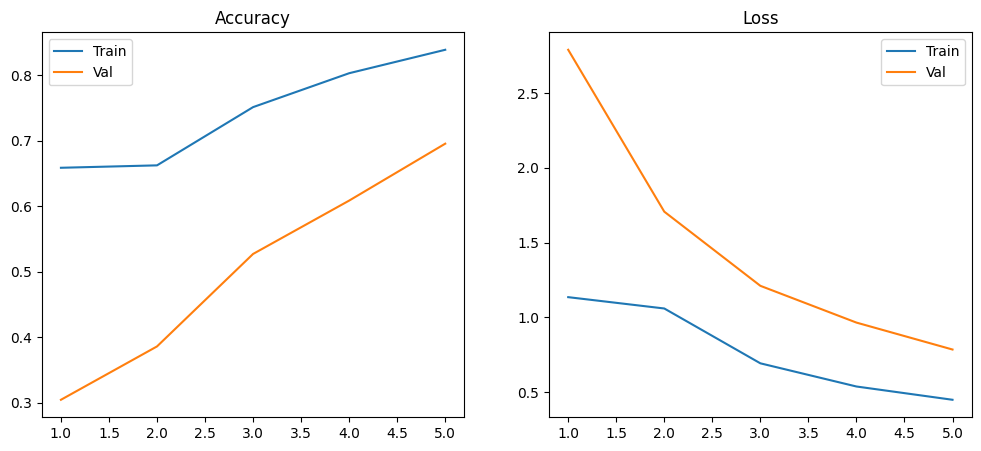

In [22]:
#grafica
acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.title("Loss")
plt.legend()

Predicciones: [3 3 0 0 3 3 3 0 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3]
Etiquetas reales: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


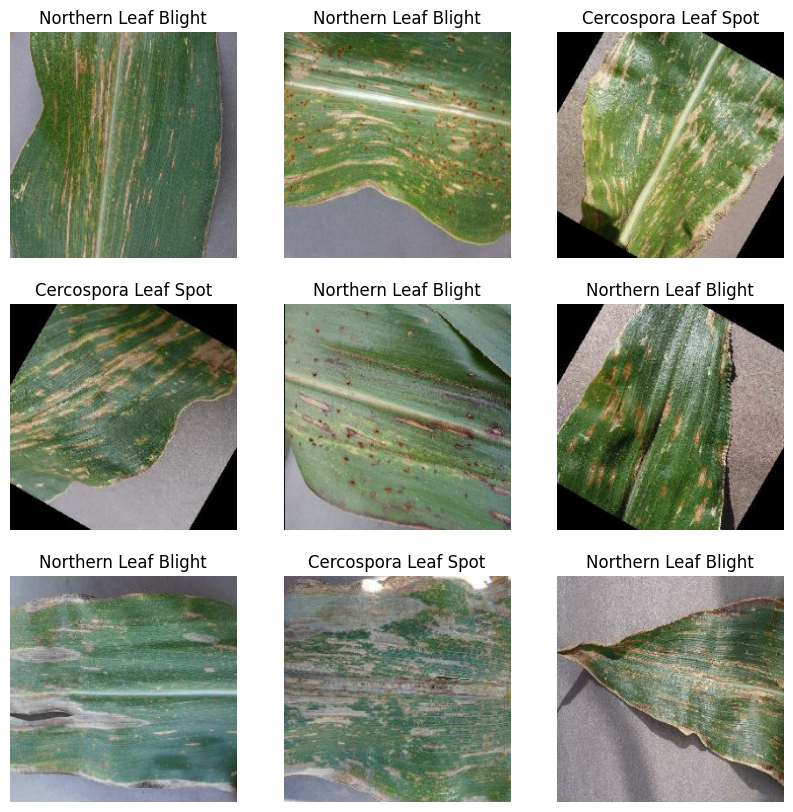

In [23]:
class_names = list(clases.keys())

image_batch, label_batch = next(iter(ds_test))
predictions = model.predict_on_batch(image_batch)

pred_labels = tf.argmax(predictions, axis=1)

print("Predicciones:", pred_labels.numpy())
print("Etiquetas reales:", label_batch.numpy())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[int(pred_labels[i])])
    plt.axis("off")
plt.show()